# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns

In [2]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print(df.head())

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [3]:
# frequency table for prestige and whether or not someone was admitted
print(df_raw.groupby('prestige').count())
print
print(df_raw.groupby('prestige').mean())

          admit  gre  gpa
prestige                 
1.0          61   61   61
2.0         150  148  149
3.0         121  121  121
4.0          67   67   67
             admit         gre       gpa
prestige                                
1.0       0.540984  611.803279  3.453115
2.0       0.353333  596.621622  3.364027
3.0       0.231405  574.876033  3.432893
4.0       0.179104  570.149254  3.318358


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [4]:
df_dums = pd.get_dummies(df_raw, columns=['prestige'])

In [5]:
df_dums.columns = ["admit", "gre", "gpa", 
                   "prestige_1", "prestige_2", "prestige_3", "prestige_4"]

### 2.2 When modeling our class variables, how many do we need? 

Answer: The classic answer is that we need 1 fewer class variables than there are classes. The excluded class becomes the reference class. However, a fuller response is that the number of class variables needed depends on the extent of colinearity between the class variables. 

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [6]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(df_dums.loc[:, 'prestige_1':])
print (handCalc.head())

   admit    gre   gpa  prestige_1  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           0           1           0
1      1  660.0  3.67           0           0           1           0
2      1  800.0  4.00           1           0           0           0
3      1  640.0  3.19           0           0           0           1
4      0  520.0  2.93           0           0           0           1


In [7]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
pd.crosstab(df_dums['admit'], df_dums['prestige_1'], rownames=['admit'], colnames=['prestige'])

prestige,0,1
admit,,
0,245,28
1,94,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

The odds ration is calculated as follows:

$$ \Psi  = \frac{admit\; vs\; fail\; when\; prestige=1}{admit\; vs\; fail\; when\; prestige =0}  = \frac{\frac{X=1\; when\; Y=1}{X=1\; when\; Y=0}}{\frac{X=0\; when\; Y=1}{X=0\; when\; Y=0}}      $$

In this particular case:

$$ \Psi = \dfrac{\frac{33}{94}} {\frac{28}{245}} = 3.07$$

In [8]:
#check with scipy
import scipy.stats as stats
arr = pd.crosstab(df_dums['admit'], df_dums['prestige_1']).values
oddsratio, pvalue = stats.fisher_exact(arr)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  3.07180851064 p-Value: 8.64077271672e-05


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [9]:
#by hand
(28/245.0)/(33/94.0)

0.3255411255411255

In [10]:
#with scipy
stats.fisher_exact(np.flip(arr, axis = 1))

(0.32554112554112552, 8.6407727167175569e-05)

#### 3.3 Calculate the odds ratio

In [11]:
float(33/94)

0.35106382978723405

#### 3.4 Write this finding in a sentenance: 

Attending a number 1 ranked college increases the log odds of being admitted to graduate school by 3.07 times. This finding is significant at 99%

#### 3.5 Print the cross tab for prestige_4

In [23]:
pd.crosstab(df_dums['admit'], df_dums['prestige_4'], rownames=['admit'], colnames=['prestige'])

prestige,0,1
admit,,
0,218,55
1,115,12


#### 3.6 Calculate the OR 

In [24]:
arr4 = pd.crosstab(df_dums['admit'], df_dums['prestige_4']).values
oddsratio, pvalue = stats.fisher_exact(arr4)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  0.413596837945 p-Value: 0.00916528495472


#### 3.7 Write this finding in a sentence

Answer: Not attending a number 1 ranked school is significant at 99%. 

Either:

1. It decreases the probability of admission as the log odds is multiplied by 0.41 or
2. It inceases the baseline probability but only by a small amount relative to 3.07 of number 1 ranked. I am not sure which (this would mean increasing odds by 1.41 times)

## Part 4. Analysis

In [25]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(df_dums.ix[:, 'prestige_2':])
print(data.head())

   admit    gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           1           0
1      1  660.0  3.67           0           1           0
2      1  800.0  4.00           0           0           0
3      1  640.0  3.19           0           0           1
4      0  520.0  2.93           0           0           1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [26]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [27]:
train_cols = ['intercept', "gre", "gpa", "prestige_2", "prestige_3", "prestige_4"]

#### 4.2 Fit the model

In [28]:
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [29]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Sep 2017   Pseudo R-squ.:                 0.08166
Time:                        15:41:17   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.8769      1.142     -3.393      0.001      -6.116      -1.638
gre            0.0022      0.001      2.028      0.043    7.44e-05       0.004
gpa            0.7793      0.333      2.344      0.019       0.128       1.431
prestige_2    -0.6801      0.317     -2.146      0.032      -1.301      -0.059
prestige_3    -1.3387      0.345     -3.882      0.000      -2.015      -0.663
prestige_4    -1.5534      0.417     -3.721      0.000      -2.372      -0.735
==============================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [30]:
np.exp(result.params)

intercept     0.020716
gre           1.002221
gpa           2.180027
prestige_2    0.506548
prestige_3    0.262192
prestige_4    0.211525
dtype: float64

In [31]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                2.5%     97.5%        OR
intercept   0.002207  0.194440  0.020716
gre         1.000074  1.004372  1.002221
gpa         1.136120  4.183113  2.180027
prestige_2  0.272168  0.942767  0.506548
prestige_3  0.133377  0.515419  0.262192
prestige_4  0.093329  0.479411  0.211525


#### 4.5 Interpret the OR of Prestige_2

The estimate on prestige_2 is not terribly precise. At the 97.5th percentile of confidence the odds ratio is almost 1, which would indicate that the odds of being admitted from a baseline school are roughly the same as the baseline odds of being admitted. At the 2.5th percentile of confidence we would expect odds roughly 27% of the baseline odds. In this case the baseline odds is coming from a number 1 ranked school. 

#### 4.6 Interpret the OR of GPA

Answer: There is no strong relationship between GRE and the odds of being admitted. The odds of being admitted increase by 2.18 for every unit of added GPA.  

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [53]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [163]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 100)
print (gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 100)
print (gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])

# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1]]))

[ 220.          225.85858586  231.71717172  237.57575758  243.43434343
  249.29292929  255.15151515  261.01010101  266.86868687  272.72727273
  278.58585859  284.44444444  290.3030303   296.16161616  302.02020202
  307.87878788  313.73737374  319.5959596   325.45454545  331.31313131
  337.17171717  343.03030303  348.88888889  354.74747475  360.60606061
  366.46464646  372.32323232  378.18181818  384.04040404  389.8989899
  395.75757576  401.61616162  407.47474747  413.33333333  419.19191919
  425.05050505  430.90909091  436.76767677  442.62626263  448.48484848
  454.34343434  460.2020202   466.06060606  471.91919192  477.77777778
  483.63636364  489.49494949  495.35353535  501.21212121  507.07070707
  512.92929293  518.78787879  524.64646465  530.50505051  536.36363636
  542.22222222  548.08080808  553.93939394  559.7979798   565.65656566
  571.51515152  577.37373737  583.23232323  589.09090909  594.94949495
  600.80808081  606.66666667  612.52525253  618.38383838  624.24242424
  630.1

#### 5.1 Recreate the dummy variables

In [164]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
combos
# keep only what we need for making predictions
combos_dums = pd.get_dummies(combos, columns=['prestige'], prefix='prestige', drop_first=True)
combos_dums.columns = ["gre", "gpa", 'intercept', "prestige_2", "prestige_3", "prestige_4"]

#### 5.2 Make predictions on the enumerated dataset

In [165]:
combos_dums['admit_predict'] = result.predict(combos_dums[train_cols])

In [166]:
combos_dums.tail(4)

,gre,gpa,intercept,prestige_2,prestige_3,prestige_4,admit_predict
39996,800.0,4.0,1.0,0,0,0,0.734040
39997,800.0,4.0,1.0,1,0,0,0.582995
39998,800.0,4.0,1.0,0,1,0,0.419833
39999,800.0,4.0,1.0,0,0,1,0.368608


#### 5.3 Interpret findings for the last 4 observations

Observation 396 has a 0.73 probability of getting admitted, and so on...

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [167]:
combos_dums['gre'].value_counts()

348.888889    400
489.494949    400
501.212121    400
255.151515    400
243.434343    400
530.505051    400
395.757576    400
764.848485    400
717.979798    400
261.010101    400
448.484848    400
542.222222    400
665.252525    400
571.515152    400
401.616162    400
284.444444    400
518.787879    400
407.474747    400
512.929293    400
612.525253    400
630.101010    400
565.656566    400
454.343434    400
800.000000    400
378.181818    400
753.131313    400
319.595960    400
735.555556    400
354.747475    400
466.060606    400
             ... 
343.030303    400
536.363636    400
758.989899    400
583.232323    400
231.717172    400
220.000000    400
296.161616    400
325.454545    400
700.404040    400
688.686869    400
794.141414    400
419.191919    400
559.797980    400
307.878788    400
600.808081    400
747.272727    400
577.373737    400
606.666667    400
495.353535    400
524.646465    400
477.777778    400
290.303030    400
302.020202    400
647.676768    400
694.545455

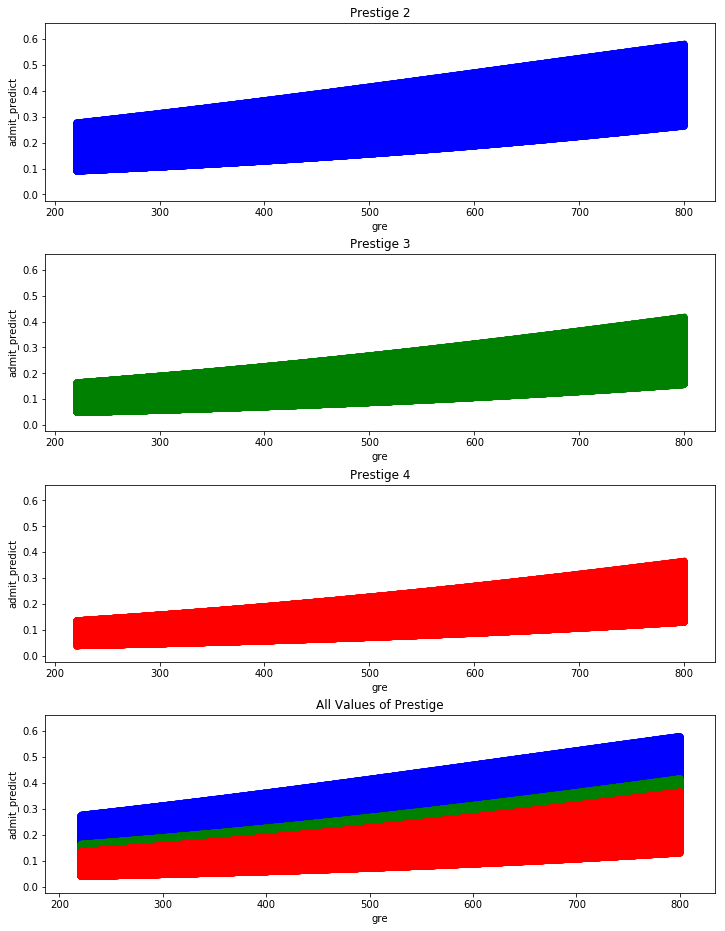

In [161]:
fig, axes = plt.subplots(4, 1, sharey=True)
colors = ['blue', 'green', 'red', ]
for e, c in enumerate(colors):
    axes[e].set_title("Prestige {}".format(e + 2))
    combos_dums[combos_dums['prestige_{}'.format(e+2)] == 1].plot(x = 'gre', y='admit_predict', 
                                                                  kind='scatter', color=c, ax=axes[e])
    combos_dums[combos_dums['prestige_{}'.format(e+2)] == 1].plot(x = 'gre', y='admit_predict', 
                                                                  kind='scatter', color=c, ax=axes[3])
plt.gcf().set_size_inches(12, 16)
plt.subplots_adjust(hspace=0.3)
axes[3].set_title("All Values of Prestige")

KeyboardInterrupt: 

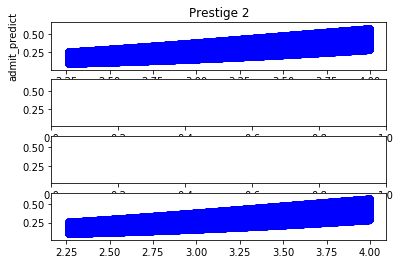

In [162]:
fig, axes = plt.subplots(4, 1, sharey=True)
colors = ['blue', 'green', 'red', ]
for e, c in enumerate(colors):
    axes[e].set_title("Prestige {}".format(e + 2))
    combos_dums[combos_dums['prestige_{}'.format(e+2)] == 1].plot(x = 'gpa', y='admit_predict', 
                                                                  kind='scatter', color=c, ax=axes[e])
    combos_dums[combos_dums['prestige_{}'.format(e+2)] == 1].plot(x = 'gpa', y='admit_predict', 
                                                                  kind='scatter', color=c, ax=axes[3])
plt.gcf().set_size_inches(12, 16)
plt.subplots_adjust(hspace=0.3)
axes[3].set_title("All Values of Prestige")